# Training the AutoEncoder on unlabeled images

First we will load the images of the experiment and save them to an .h5 file for convenience.<br>Then we will use the images to train an autoencoder for feature extraction.

## Loading the dataset

In [2]:
import numpy as np
import pandas as pd
#np.random.seed(1)
import time
import h5py
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from decafx.cae_architectures import cae_indepIn

#%% load the data from the .h5 file
h5f = h5py.File('./data/X_M1.h5','r')
#h5f.visit(print)#print all filenames in the file
X = h5f['X'][()]#images
y = h5f['y'][()]#labels
#fnames = h5f['fnames'][()]
h5f.close()

#y==0: apoptotic cell
#y==1: non-apoptotic cell

# Exploring the dataset

Let's get a feeling for the dataset, namely:
- Total number of cells
- Image properties (size and channels)
- Distribution of cells in the two classes
- Plot an image of a cell to see what it looks like

Total cells in the dataset: 15311
Size of each image: ( 32 , 32 )
Number of channels: 2


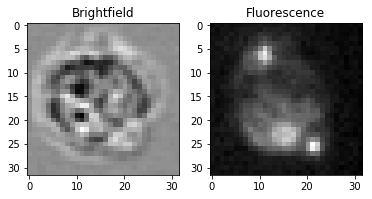

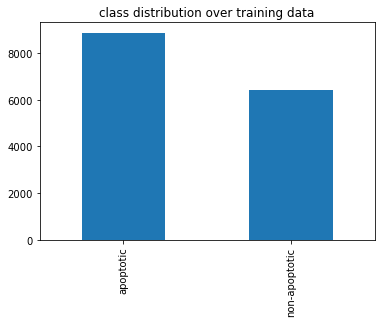

In [3]:
#find the total number of cells, image size and number of channels
cells_total=X.shape[0]
imsize_x=X.shape[1]
imsize_y=X.shape[2]
imsize=(imsize_x,imsize_y)
nchannels=X.shape[3]
print('Total cells in the dataset:',cells_total)
print('Size of each image: (',imsize_x,',',imsize_y,')')
print('Number of channels:',nchannels)

#plot the image of a cell
plt.figure()
plt.subplot(1,2,1)
plt.imshow(X[0,:,:,0],cmap='gray')
plt.title('Brightfield')
plt.subplot(1,2,2)
plt.imshow(X[0,:,:,1],cmap='gray')
plt.title('Fluorescence')

#plot histogram of class distribution
plt.figure()
s=pd.Series(y).astype('category')#create pandas series
s.cat.rename_categories(['apoptotic','non-apoptotic'],inplace=True)#rename categories
pd.value_counts(s).plot(kind='bar')
plt.title('class distribution over training data')
plt.show()

## Training the AutoEncoder

We will split the training data into a training and validation set.
<br>Then we will train an autoencoder (with separate channel encoders).
<br><br>The best model will be saved to **cae_M1.hdf5**


In [ ]:
#split into training and validation data
#use 10% of the data as a validation set
#random_state=1 to get repeatable results
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.1, random_state=1)

filepath="cae_M1" #to save the best model
#we use a checkpoint to save only the best model according to validation loss
checkpoint = ModelCheckpoint(filepath+'.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#we will also save the training progress on a .csv file
csvlog = CSVLogger(filepath+'_train_log.csv',append=True)

model = cae_indepIn(nchannels=nchannels)#initialize the autoencoder

#now fit the model, we need to supply the input channels separately to the model
#some reshaping is required to fit the input shapes expected by the model
model.fit([X_tr[:,:,:,0].reshape(X_tr.shape[0], imsize[0], imsize[0], 1),
                  X_tr[:,:,:,1].reshape(X_tr.shape[0], imsize[0], imsize[0], 1)], X_tr,
                 validation_data=([X_val[:,:,:,0].reshape(X_val.shape[0], imsize[0], imsize[0], 1),
                                   X_val[:,:,:,1].reshape(X_val.shape[0], imsize[0], imsize[0], 1)], X_val),
                 epochs=300, batch_size=64, verbose=2,
                 initial_epoch=0,callbacks=[checkpoint, csvlog])

Train on 13779 samples, validate on 1532 samples
Epoch 1/300
